## CVMA (H) Image Transformations & Training Latent Spaces in Deep Convolutional Autoencoder Neural Networks
### Max Kirker Burton
### 2260452b

<font color="red"> This exercise is my own work. </font>

In [0]:
## Standard imports
import numpy as np
import cv2
#from bitstring import Bits, BitArray, BitStream
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal
import skimage.morphology, skimage.transform, skimage.feature
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 6.0)

#standard utilities
def show_gray(img, title, **kwargs):
    plt.figure()
    plt.imshow(img, cmap="gray",  **kwargs)
    plt.axis("off")
    plt.title(title)
    
def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

### RGB/YIQ conversion code
yiq_mat =  np.array([[ 0.30, 0.59, 0.114],[0.599, 0.2773, 0.3217],[0.213,0.5251,0.3121]])
rgb_mat =  np.linalg.inv(yiq_mat)

def rgb_to_yiq(rgb):
    # RGB to YIQ
    return np.dot(rgb, yiq_mat)    
    
def yiq_to_rgb(yiq):
    # convert YIQ to RGB     
    return np.clip(np.dot(yiq,rgb_mat),0,1)  

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
// this cell fixes the scroll boxes that are otherwise quite irritating

<IPython.core.display.Javascript object>

## Baseline DCNN code for classifying the MNIST dataset:

Hardware Processing Device: cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333672
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.312442
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.233292
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.250765
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.224224
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.233881
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.170592
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.209160
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.067586
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.031920
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.976195
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.830733
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.896484
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.738995
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.899557
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.411737
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.459690
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.550470
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.415272
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.592

No handles with labels found to put in legend.



Test set: Average loss: 0.4141, Accuracy: 8449/10000 (84%)



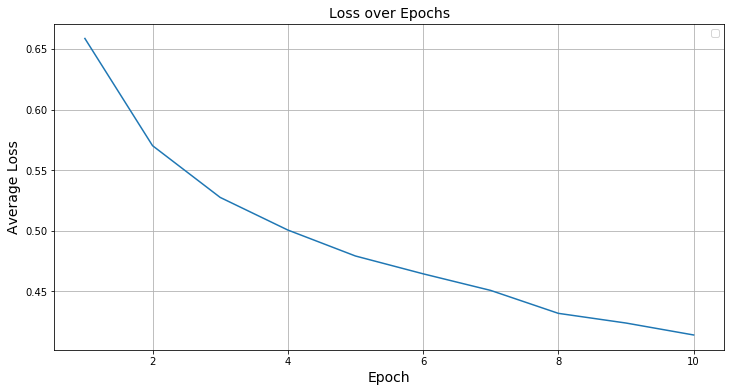

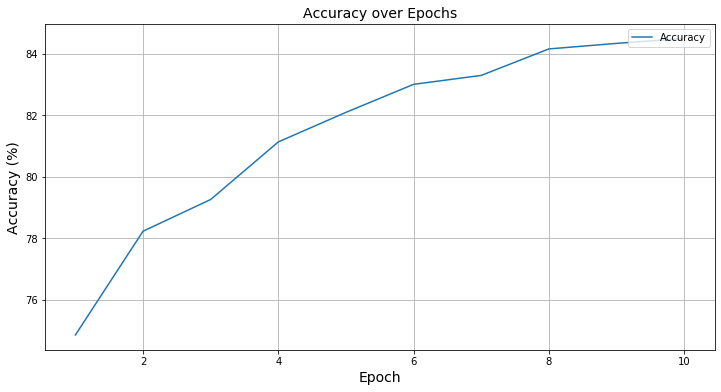

[0.6586100646972656, 0.5702023132324219, 0.5275187927246093, 0.5006154296875, 0.4791991577148437, 0.4645125915527344, 0.4507993347167969, 0.43189379577636716, 0.42391036987304687, 0.41405750427246096]
[74.86, 78.23, 79.25999999999999, 81.13, 82.09, 83.0, 83.28999999999999, 84.15, 84.33, 84.49]


In [9]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
        x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct, len(test_loader.dataset)

def main():
    # Training settings
    # description='PyTorch MNIST Example'
    # --batch-size', type=int, default=64, metavar='N', help='input batch size for training (default: 64)
    # --test-batch-size', type=int, default=1000, metavar='N', help='input batch size for testing (default: 1000)
    # --epochs', type=int, default=10, metavar='N', help='number of epochs to train (default: 10)
    # --lr', type=float, default=0.01, metavar='LR', help='learning rate (default: 0.01)
    # --momentum', type=float, default=0.5, metavar='M', help='SGD momentum (default: 0.5)
    # --no-cuda', action='store_true', default=False, help='disables CUDA training
    # --seed', type=int, default=1, metavar='S', help='random seed (default: 1)
    # --log-interval', type=int, default=10, metavar='N', help='how many batches to wait before logging training status
    #
    use_cuda = not False and torch.cuda.is_available()

    torch.manual_seed(1)

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Hardware Processing Device:', device)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=64, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True, **kwargs)


    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    avg_loss = []
    correct = []
    epoch_range = range(1, 10 + 1)
    for epoch in epoch_range:
        train(model, device, train_loader, optimizer, epoch)
        loss, corr, total = test(model, device, test_loader)
        avg_loss.append(loss)
        correct.append((corr/total)*100)

    plt.plot(epoch_range, avg_loss)
    plt.title('Loss over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Average Loss', fontsize=14)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

    plt.plot(epoch_range, correct, label="Accuracy")
    plt.title('Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()


main()

## Introduction
* To investigate how performance of an autoencoder can be improved by modifying several parameters.
* To compare the performance of an autoencoder on noisy images, and comparing that to the baseline of the image without noise
* To compare the performance of an autoencoder on image transformations
* To compare the performance of an individual and combined networks


## Approach
Unfortunately due to time constraints only phase 1 has been completed, but I will continue work on this over the winter break

## Process
[Put your code here, explaining it in markdown cells. ]

## Evaluation
[Explain the experiments you performed. Include example plots of the loss and accuracy results for your best parameterisation of each network/filter set you develop.]

## Results
Baseline plots:
![Classify Baseline loss](./imgs/baseline_loss.png)
![Classify Baseline accuracy](./imgs/baseline_accuracy.png)
Encoder baseline plot:
![Encoder Baseline loss](./imgs/e_baseline_loss.png)

## Conclusions
[briefly summarise what you have done. Discuss how well the baseline, optimsed, Gabor filter and your own filter networks perform, and how you might design and improved network based on using defined filter kernels.]